# Required modules

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random

from types import MethodType

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from utilities.data_downloader import train_val_test_downloader, choose_one_column
from utilities.plots import visualize_latent, errorbar_plot_collection, COLORMAP

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KernelDensity
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline

In [5]:
random.seed(42)
np.random.seed(42)

# Description

## Features
We study two feature collections:

- **FeatureExtractor**-induced features (see dataset/README.md for a detailed discussion). 
- Rebinned and interpolated countrate lightcurves identified with pseudo-tabular features

## KernelPCA
Independently from the kind of dataset, **KernelPCA** is utilized as follows:
1. The data are preprocessed by median-based SimpleImputer and RobustScaler. Importantly for the anomaly detection, both are robust to outliers.
2. Next, the **KernelPCA** output space are identified with the newly-extracted features. To deal with a quantitative criterion, we fit **KernelDensity** to the output distribtuion, and then score samples accordingly. The bandwidth is fixed according to Silverman's rule of thumb, see [[archive.org]](https://archive.org/details/densityestimatio00silv_0/page/44/mode/2up)
3. We identify these scores as anomalous scores and compute ROC_AUC with the flag denoting whether there any X-Ray flares detected by *Swift*-XRT semi-manual analysis..
4. The **KernelPCA** hyperparameters are optimized using GridSearchCV to maximize the cross-validation-average of the ROC_AUC on the training set.
5. We finally study the best found estimator scores and the corresponding **KernelPCA** features.

## Visualization
We visualize the features transformed by **KernelPCA**. The color on the plots denotes the number of breaks in lightcurve trend detected by *Swift*-XRT semi-manual analysis. To measure the relation quantitatively, we calculate the correlation coefficient between the embedding coordinates and the number of breaks.

## Other
To make the results more interpretable, we also display the 10 most-anomalous-scored GRBs.

# Analysis Pipeline

In [6]:
def roc_auc_scoring(estimator, X, y)->float:
    yscore = -estimator.score_samples(X) # anomalous samples have smaller log-likelihood
    ytrue = y
    return roc_auc_score(ytrue, yscore)

In [7]:
def make_pipe(kernels:tuple):
    """
    Makes GridSearchCV pipeline
    """
    return Pipeline(
        [('imputer', SimpleImputer(
            missing_values=np.nan, strategy='median')),
         ('scaler', RobustScaler()),
         ('model', GridSearchCV(
             Pipeline([
                 ('KernelPCA', KernelPCA(random_state=42)),
                 ('KDE', KernelDensity(kernel='gaussian', bandwidth='silverman'))
             ]),
             param_grid={
                 'KernelPCA__n_components': (1, 2, 3),
                 'KernelPCA__kernel': kernels,
                 'KernelPCA__gamma': (0.1, 0.3, 1.0, 3.0)},
             scoring=roc_auc_scoring, cv=2),
         ),
        ]
    )

In [8]:
def transform_dataset(pipe:Pipeline,
                      train:pd.DataFrame,
                      val:pd.DataFrame,
                      test:pd.DataFrame,
                      labels:pd.DataFrame)->pd.DataFrame:
    """
    Creates a joint dataframe of transformed features.
    """
    train_df, val_df, test_df = [
        pd.DataFrame(data=pipe.transform(df), index=df.index).rename(
        columns=lambda col: f'feature_{col}') for df in (train, val, test)
    ]
    train_df['score'], val_df['score'], test_df['score'] = [
        pipe.score_samples(df) for df in (train, val, test)
    ]
    train_df['sample'] = 'train'
    val_df['sample'] = 'val'
    test_df['sample'] = 'test'
    df = pd.concat((train_df, val_df, test_df), axis=0, ignore_index=False)
    df = pd.concat((df, labels), axis=1, ignore_index=False)
    return df

# Extracted Features Analysis

In [9]:
train, val, test, labels = train_val_test_downloader('features')
ytrain, yval, ytest = (
    labels.loc[train.index, 'FlaresFlag'],
    labels.loc[val.index, 'FlaresFlag'],
    labels.loc[test.index, 'FlaresFlag']
)

Datasets downloaded
 - train  : 810 entries
 - val    : 174 entries
 - test   : 174 entries
 - labels : 1158 entries


In [10]:
pipe = make_pipe(kernels=('rbf', 'sigmoid', 'cosine'))
pipe.fit(train, ytrain)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('model',
                 GridSearchCV(cv=2,
                              estimator=Pipeline(steps=[('KernelPCA',
                                                         KernelPCA(random_state=42)),
                                                        ('KDE',
                                                         KernelDensity(bandwidth='silverman'))]),
                              param_grid={'KernelPCA__gamma': (0.1, 0.3, 1.0,
                                                               3.0),
                                          'KernelPCA__kernel': ('rbf',
                                                                'sigmoid',
                                                                'cosine'),
                                          'KernelPCA__n_components': (1, 2, 3)},
                              scoring=<function roc_auc_scoring at 0x15732bc40>))])

In [11]:
def transform(self, dataframe:pd.DataFrame):
    return self._final_estimator.best_estimator_[0].transform(
        self[1].transform(
            self[0].transform(dataframe)
        )
    )
pipe.transform = MethodType(transform, pipe)

In [12]:
# Flares detection best score
pipe._final_estimator.best_score_

0.5712251967523434

In [13]:
# Optimal parameters
pipe._final_estimator.best_params_

{'KernelPCA__gamma': 0.1,
 'KernelPCA__kernel': 'cosine',
 'KernelPCA__n_components': 3}

In [14]:
print('ROC-AUC Score:\n'+
      f'    train : {round(roc_auc_scoring(pipe, train, ytrain), 2)}\n'+
      f'    val   : {round(roc_auc_scoring(pipe, val, yval), 2)}\n'+
      f'    test  : {round(roc_auc_scoring(pipe, test, ytest), 2)}'
     )

ROC-AUC Score:
    train : 0.56
    val   : 0.57
    test  : 0.54


In [15]:
df = transform_dataset(pipe, train, val, test, labels)

In [16]:
# top-10 anomalous
top10anomalous = df.sort_values(by='score', axis=0).head(10)
top10anomalous

,feature_0,feature_1,feature_2,score,sample,numbreaks,lc type,NH_gal,Redshift,Flares,FlaresFlag
GRB 060801,-0.219559,0.334246,0.709173,-2.518056,train,0,No breaks,0.0143,1.1300,[],0
GRB 231210B,-0.180890,0.228669,0.768441,-2.512724,val,2,Canonical,0.0405,3.1300,[],0
GRB 051006,-0.243564,0.207045,0.711808,-2.365231,val,0,No breaks,0.0987,1.0590,[],0
GRB 090510,-0.294980,0.261686,0.649915,-2.304133,train,1,One-break,0.0177,0.9030,[],0
GRB 210725A,-0.116223,0.101768,0.756685,-2.299697,train,0,No breaks,0.0409,NaN,[],0
GRB 201021C,-0.156779,0.445844,0.554055,-2.282448,test,0,No breaks,0.0205,1.0700,[],0
GRB 090419,-0.469341,0.288768,0.601820,-2.273786,train,0,No breaks,0.2200,NaN,"[(308, 564)]",1
GRB 150301B,-0.152664,0.013025,0.785961,-2.214538,train,0,No breaks,0.0615,1.5169,[],0
GRB 200306C,-0.149675,0.015408,0.782996,-2.212788,train,1,One-break,0.0191,NaN,"[(867, 1392)]",1
GRB 220319A,0.364043,0.826588,0.178064,-2.205628,val,0,No breaks,0.0149,NaN,[],0


In [17]:
top10 = list(top10anomalous.index)
other = [grb for grb in df.index if grb not in top10]

event_names = top10 + other
colors = [COLORMAP(0.7)] * len(top10) + [COLORMAP(0.3)] * len(other)

In [19]:
!curl -o ./tmp/tmp.json 'https://raw.githubusercontent.com/Nickolay-Martynenko/GRB-X-Ray-Afterglow/main/dataset/SwiftXRT/PC_incbad/GRB 221009A'

curl: (3) URL rejected: Malformed input to a URL function


0it [00:00, ?it/s]curl: (3) URL rejected: Malformed input to a URL function
curl: (3) URL rejected: Malformed input to a URL function
0it [00:00, ?it/s]


ValueError: No objects to concatenate

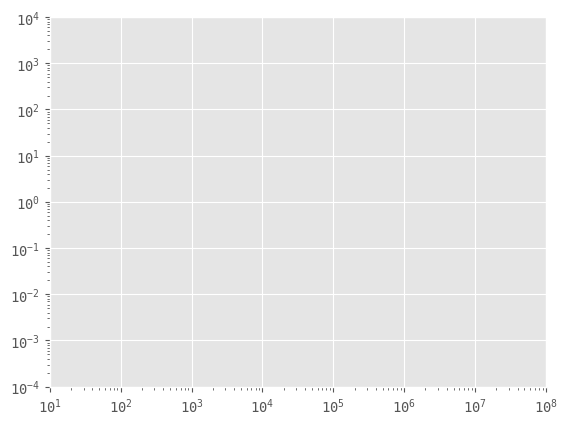

In [18]:
if not os.path.isdir('./Figures'):
    os.mkdir('./Figures')
errorbar_plot_collection(event_names, colors,
                         title='best KernelPCA on LC features: top-10',
                         savedir='./Figures', show=True)

In [ ]:
fragment = df[
    [col for col in df.columns if col.startswith('feature_')]+
    ['numbreaks']
].values

print('correlation between latent features and '+
      f'numbreaks: {np.corrcoef(fragment, rowvar=False)[:-1, -1]}'
)

In [ ]:
visualize_latent(df, title='best KernelPCA on LC features',
                 savedir='./Figures', show=True)

Despite a notable correlation between the extracted feature space and number of breaks, no significant anomalies found. The X-Ray flares detection score is close to random.

# Rebinned Lightcurves Analysis (Interpolated LCs)

In [ ]:
train, val, test, labels = train_val_test_downloader('interp')
train, val, test = tuple(
    map(lambda df: choose_one_column(df, 'lgRate'),
    (train, val, test))
)
ytrain, yval, ytest = (
    labels.loc[train.index, 'FlaresFlag'],
    labels.loc[val.index, 'FlaresFlag'],
    labels.loc[test.index, 'FlaresFlag']
)

In [ ]:
pipe = make_pipe(kernels=('linear', 'rbf', 'sigmoid', 'cosine'))
pipe.fit(train, ytrain)

In [ ]:
def transform(self, dataframe:pd.DataFrame):
    return self._final_estimator.best_estimator_[0].transform(
        self[1].transform(
            self[0].transform(dataframe)
        )
    )
pipe.transform = MethodType(transform, pipe)

In [ ]:
# Flares detection best score
pipe._final_estimator.best_score_

In [ ]:
# Optimal parameters
pipe._final_estimator.best_params_

In [ ]:
print('ROC-AUC Score:\n'+
      f'    train : {round(roc_auc_scoring(pipe, train, ytrain), 2)}\n'+
      f'    val   : {round(roc_auc_scoring(pipe, val, yval), 2)}\n'+
      f'    test  : {round(roc_auc_scoring(pipe, test, ytest), 2)}'
     )

In [ ]:
df = transform_dataset(pipe, train, val, test, labels)

In [ ]:
# top-10 anomalous
df.sort_values(by='score', axis=0).head(10)

In [ ]:
fragment = df[
    [col for col in df.columns if col.startswith('feature_')]+
    ['numbreaks']
].values

print('correlation between latent features and '+
      f'numbreaks: {np.corrcoef(fragment, rowvar=False)[:-1, -1]}'
)

In [ ]:
if not os.path.isdir('./Figures'):
    os.mkdir('./Figures')
visualize_latent(df, title='best KernelPCA on interpolated LCs',
                 savedir='./Figures', show=True)

The output distribution is ill-defined because of low dimensionality. No reliable anomalies found.